In [156]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import shap
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from scipy.stats import pearsonr
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
import tensorflow as tf
import PIL
import requests
from matplotlib import cm

In [104]:
filename = "android-work\\testing.xlsx"
train_path = "android-work\\train"
validation_path = "android-work\\val"
test_path = "android-work\\test"

In [67]:
df = pd.read_excel(filename)
df_cic= df[df['Family'].isin(['airpush', 'dowgin'])]
family_counts=df_cic['Family'].value_counts()
family_counts

Family
airpush    2017
dowgin      910
Name: count, dtype: int64

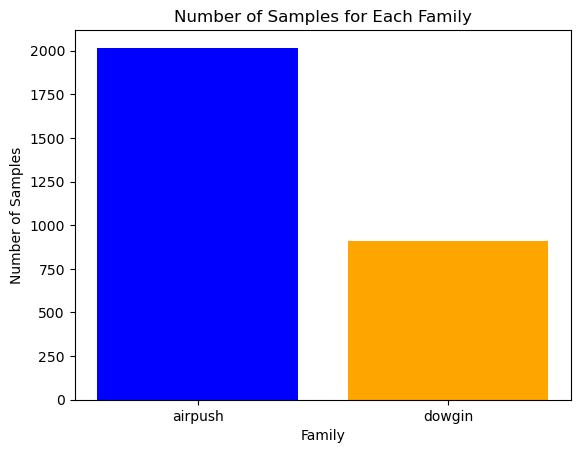

In [123]:
plt.bar(family_counts.index, family_counts.values, color=['blue', 'orange'])
plt.xlabel('Family')
plt.ylabel('Number of Samples')
plt.title('Number of Samples for Each Family')
plt.show()

In [68]:
df.drop(columns=['Hash', 'Category'], axis=1, inplace=True)

encoder = LabelEncoder()
df['Label'] = encoder.fit_transform(df['Family'])

df.drop(columns = 'Family' ,axis=1, inplace=True)
y = df['Label'] 
X = df.drop(columns = 'Label', axis=1)

scaler = StandardScaler()
X = scaler.fit_transform(X)

In [69]:
zero_variance_columns= df.columns[df.var() == 0]
print(zero_variance_columns)


df = df.drop(columns= zero_variance_columns)

correlation_matrix=np.corrcoef(df, rowvar=False, ddof=1)

Index(['Memory_SwapPssDirty', 'Memory_AssetManagers',
       'API_Process_android.os.Process_start',
       'API_Process_android.app.ActivityManager_killBackgroundProcesses',
       'API_JavaNativeInterface_java.lang.Runtime_loadLibrary',
       'API_JavaNativeInterface_java.lang.Runtime_load',
       'API_WebView_android.webkit.WebView_postUrl',
       'API_WebView_android.webkit.WebView_postWebMessage',
       'API_WebView_android.webkit.WebView_savePassword',
       'API_WebView_android.webkit.WebView_setHttpAuthUsernamePassword',
       'API_WebView_android.webkit.WebView_getHttpAuthUsernamePassword',
       'API_Database_android.database.sqlite.SQLiteDatabase_create',
       'API_IPC_android.content.ContextWrapper_sendStickyBroadcast',
       'API_DeviceInfo_android.net.wifi.WifiInfo_getNetworkId',
       'API_DeviceInfo_android.content.pm.PackageManager_getInstallerPackageName',
       'API_DeviceInfo_android.content.pm.PackageManager_getInstalledApplications',
       'API_Device

C:\Users\jummy\AppData\Local\Temp\ipykernel_18012\2834183035.py:7: DeprecationWarning: bias and ddof have no effect and are deprecated
  correlation_matrix=np.corrcoef(df, rowvar=False, ddof=1)


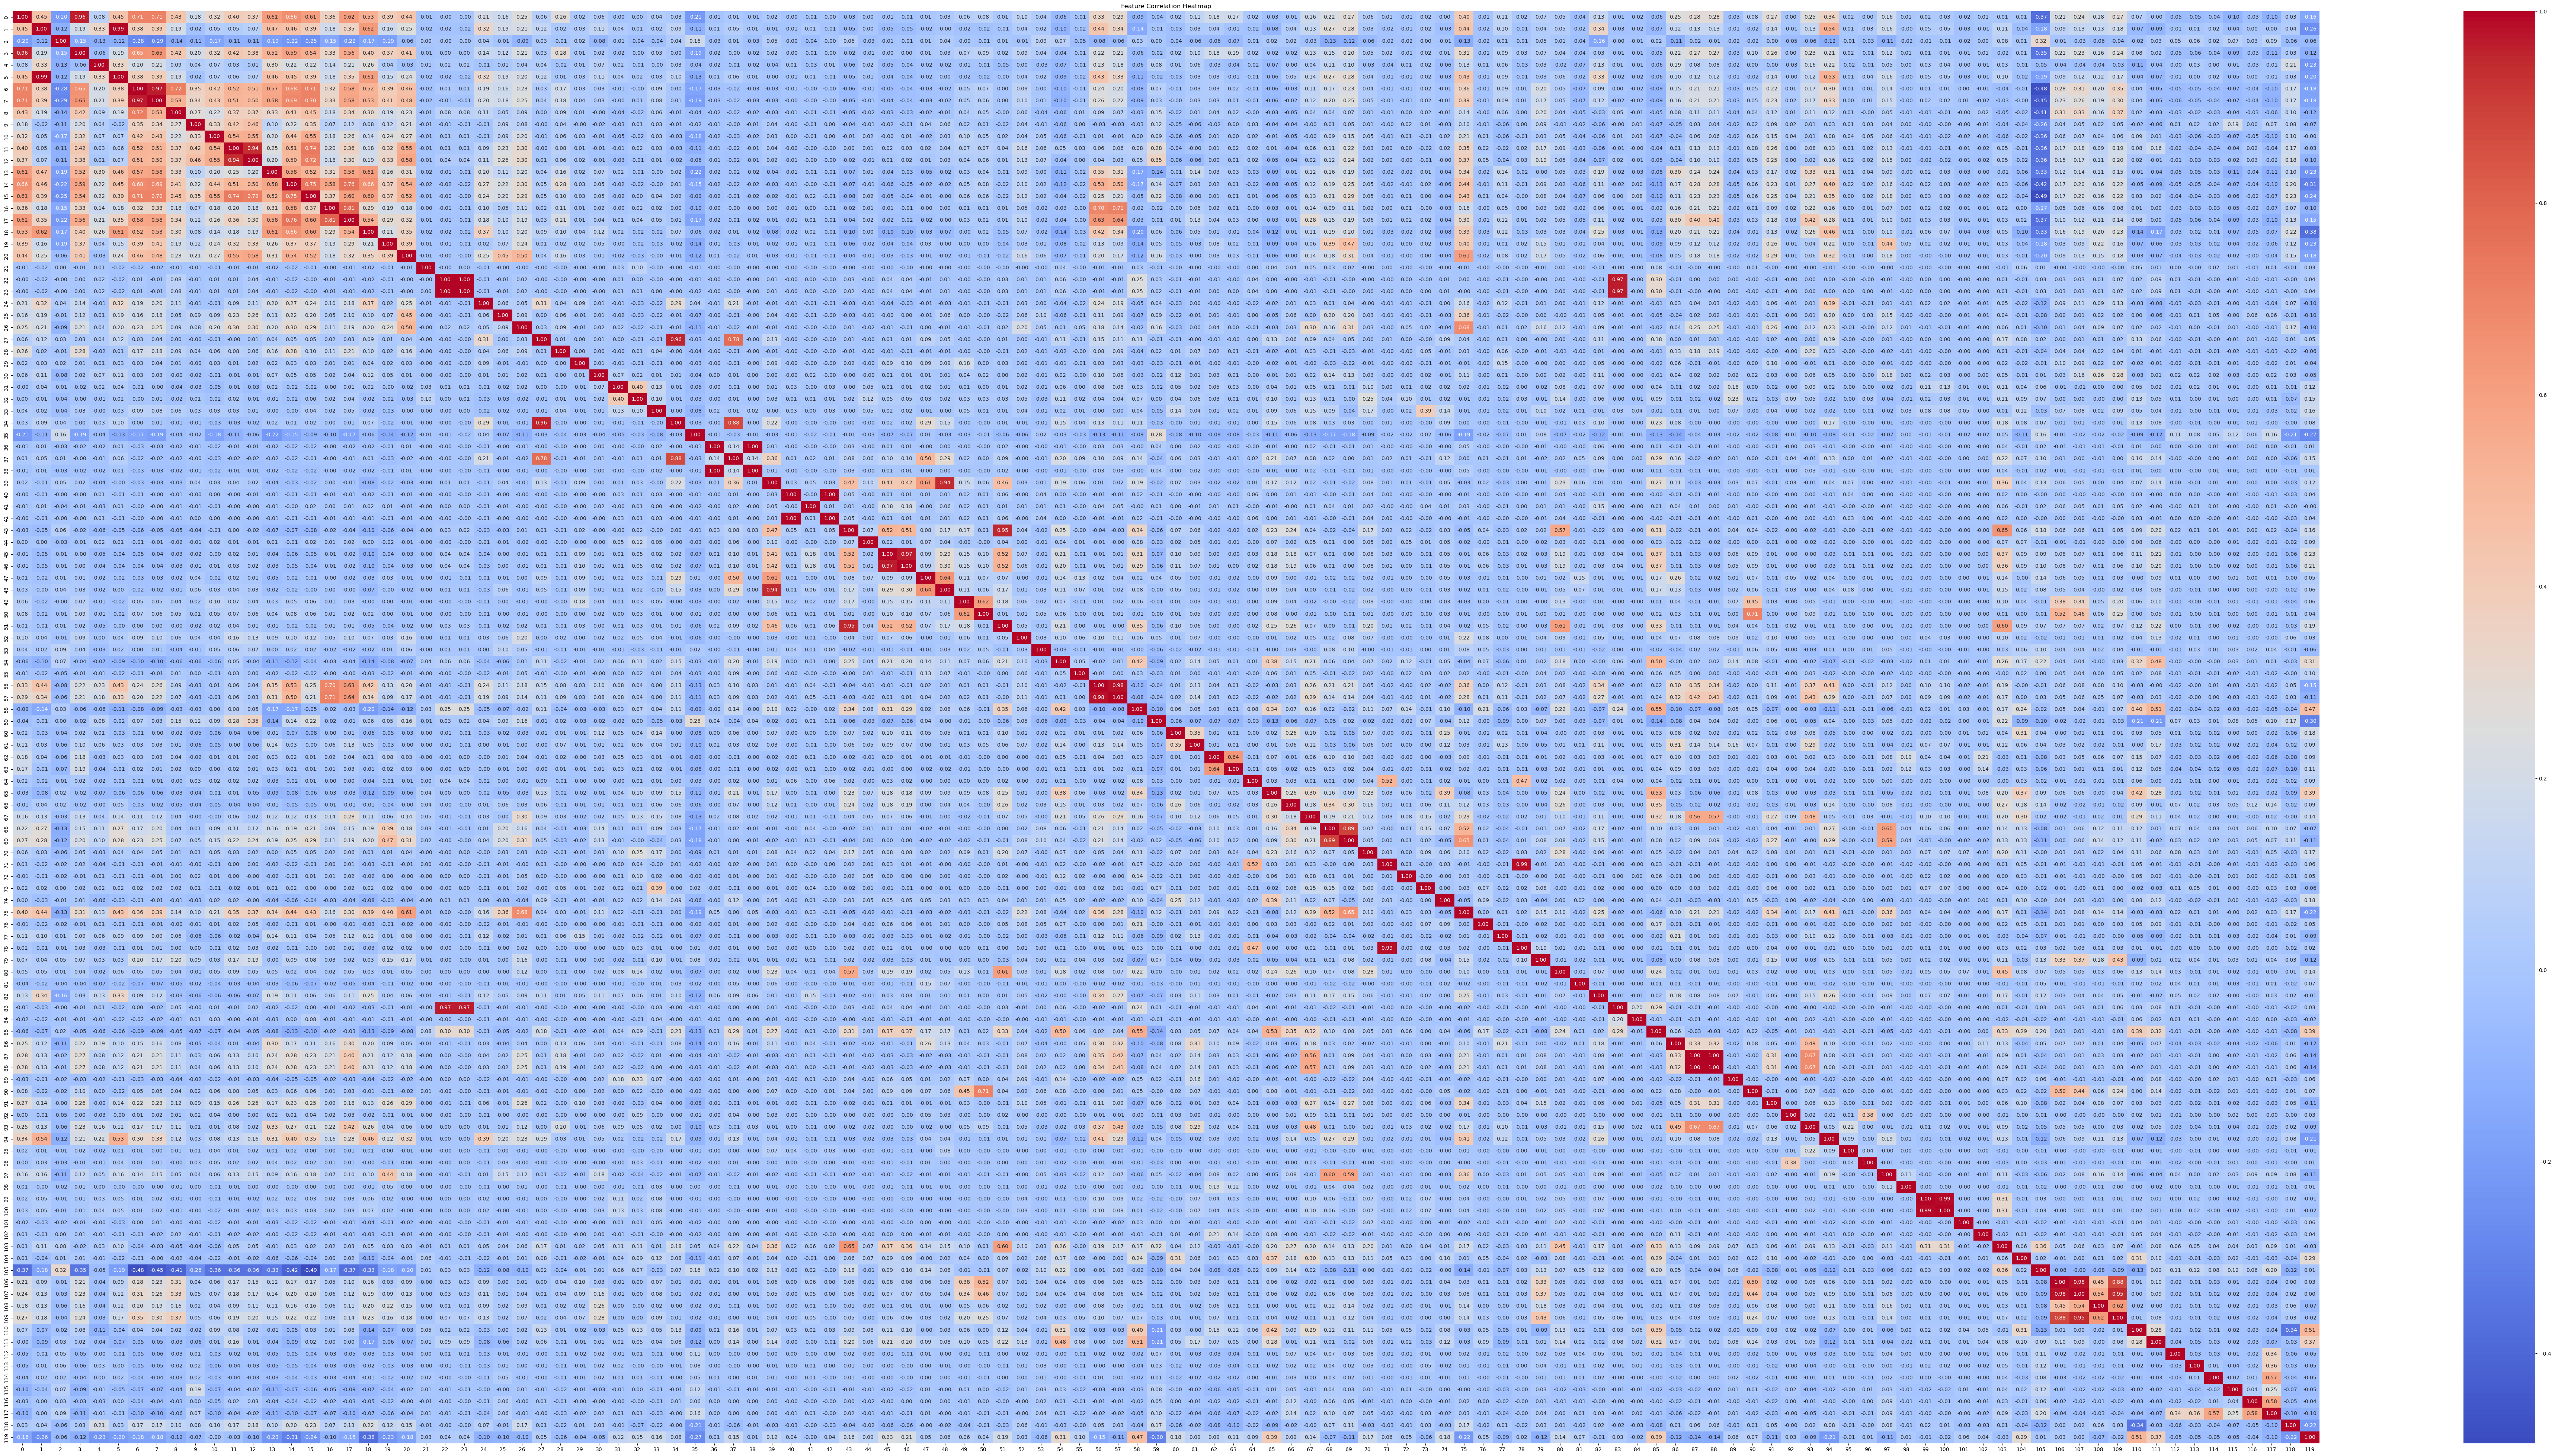

In [70]:
plt.figure(figsize=(100,50))
sns.heatmap(correlation_matrix,annot =True, fmt= ".2f", cmap= "coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

In [76]:
classifiers = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=30),
    'Logistic Regression': LogisticRegression(random_state=0),
    'Adaboost': AdaBoostClassifier()
}

param_grids = {
    'Random Forest': {'classifier__n_estimators': [50, 60, 57]},
    'Decision Tree': {'classifier__max_depth': [None, 10, 20, 30]},
    'Logistic Regression': {'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]},
    'Adaboost': {'classifier__n_estimators': [50, 100, 200], 'classifier__learning_rate': [0.01, 0.1, 1]}
}

selected_features_by_classifier = {}

for clf_name, clf in classifiers.items():
    pipeline = Pipeline([
        ('feature_selection', RFE(estimator=DecisionTreeClassifier(), n_features_to_select=56)),
        ('classifier', clf)
    ])

    param_grid = param_grids[clf_name]
    grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5)

    grid_search.fit(X_train, y_train)

    best_rfe_estimator = grid_search.best_estimator_

    X_train_rfe = best_rfe_estimator.named_steps['feature_selection'].transform(X_train)
    X_test_rfe = best_rfe_estimator.named_steps['feature_selection'].transform(X_test)

    selected_features_by_classifier[clf_name] = np.where(best_rfe_estimator.named_steps['feature_selection'].support_)[0]

common_features = set(selected_features_by_classifier[next(iter(classifiers))])
for _, features in selected_features_by_classifier.items():
    common_features.intersection_update(features)

C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

In [77]:
common_features = list(common_features)
print(f"Common set of {len(common_features)} features selected by most classifiers: {common_features}")

Common set of 37 features selected by most classifiers: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 131, 12, 132, 17, 18, 20, 41, 43, 44, 64, 71, 76, 77, 78, 81, 83, 85, 87, 88, 89, 90, 93, 96, 98, 105, 125]


In [80]:
X_train_rfe_selected = X_train[:, common_features] #selected the common features
X_test_rfe_selected = X_test[:, common_features]

In [85]:
pca_pipeline = Pipeline([
    ('pca', PCA()),
])

param_grid = {
    'pca__n_components': range(1,37),
}

grid_search = GridSearchCV(pca_pipeline, param_grid=param_grid, cv=5)

grid_search.fit(X_train_rfe_selected)

best_pca_estimator = grid_search.best_estimator_

X_train_pca = best_pca_estimator.transform(X_train_rfe_selected)
X_test_pca = best_pca_estimator.transform(X_test_rfe_selected)

print("Best parameters:", grid_search.best_params_)

Best parameters: {'pca__n_components': 34}


C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\decomposition\_base.py:77: RuntimeWarning: divide by zero encountered in divide
  precision.flat[:: len(precision) + 1] += 1.0 / exp_var_diff
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 811, in _score
    scores = scorer(estimator, X_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 527, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 753, in score
    return self.steps[-1][1].score(Xt, y, **score_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^

In [86]:
pca_columns = [f'PC{i}' for i in range(1, grid_search.best_params_['pca__n_components']+ 1)]
df_x_train_pca_cic = pd.DataFrame(data=X_train_pca, columns=pca_columns)
df_x_train_pca_cic.head()

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0 -3.239878 -0.726925  0.361355  0.152998 -0.002087  0.105955  0.456408   
1 -3.365479 -1.090162 -0.128738  0.257339  0.670317 -0.303631  0.268412   
2  1.548134 -0.050286 -0.127685 -0.042646  0.722665 -1.154741  1.165287   
3  0.002741 -1.365170  0.436593 -0.016039 -0.368749 -0.049646 -0.173307   
4 -0.611096 -0.556761 -1.466885 -0.234184  0.120407  0.011091 -0.758056   

        PC8       PC9      PC10  ...      PC25      PC26      PC27      PC28  \
0  0.496979 -0.109136 -0.302085  ...  0.598809 -0.430695 -0.352728 -0.157158   
1 -0.253791  0.561480 -0.768505  ... -0.387843 -0.111156  0.374810  0.134918   
2 -1.061898  0.612376  0.246243  ...  0.499796  0.301452  0.164794 -1.188478   
3 -0.304353  0.087077  0.324535  ... -0.430264 -0.212676  0.279753  0.146762   
4  0.345005 -0.547852  0.007084  ...  0.111392  0.178528 -0.084264  0.080798   

       PC29      PC30      PC31      PC32      PC33      PC34  
0  0.055424 -0.001085 -0.140654 -0.402290 -0.024848  0.085379  
1  0.169264  0.025074 -0.055704  0.044785 -0.004295  0.024258  
2  0.606466  0.048689 -0.102218 -0.117827 -0.041274  0.030912  
3  0.020552  0.047483 -0.031935  0.023096 -0.027345 -0.034069  
4 -0.000179 -0.038480 -0.051256 -0.013040 -0.032011 -0.013595  

[5 rows x 34 columns]

In [87]:
explained_variance_ratio = best_pca_estimator.named_steps['pca'].explained_variance_ratio_
print("Explained Variance Ratio:", explained_variance_ratio)

Explained Variance Ratio: [1.83709503e-01 8.20974866e-02 6.69492848e-02 5.25585187e-02
 4.77886357e-02 4.33292463e-02 4.01746489e-02 3.55289124e-02
 3.52485524e-02 3.50360248e-02 3.20456163e-02 3.09412478e-02
 3.04110750e-02 2.70080725e-02 2.55802994e-02 2.41297458e-02
 2.17590306e-02 2.03703436e-02 1.93489167e-02 1.83370538e-02
 1.63267180e-02 1.57902276e-02 1.52640377e-02 1.44238602e-02
 1.26931058e-02 1.07722392e-02 1.01536925e-02 8.29421699e-03
 7.80803551e-03 7.17563156e-03 5.54079238e-03 3.22705340e-03
 1.28358240e-04 4.98156691e-05]


In [88]:
cumulative_explained_variance_ratio = np.cumsum(best_pca_estimator.named_steps['pca'].explained_variance_ratio_)

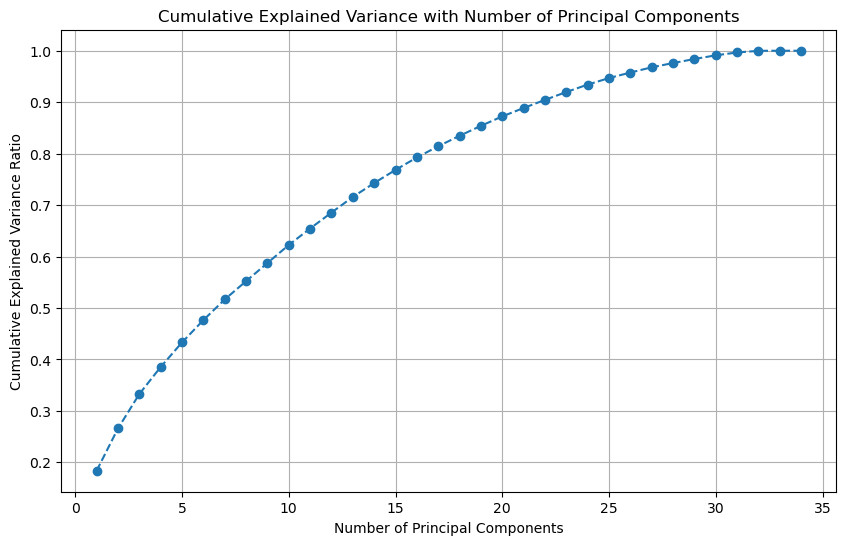

In [89]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_explained_variance_ratio) + 1), cumulative_explained_variance_ratio, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance with Number of Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid(True)
plt.show()

In [91]:
correlations, p_values = [], []
for feature_idx in range(X_train_pca.shape[1]):
    correlation, p_value = pearsonr(X_train_pca[:, feature_idx], y_train)
    correlations.append(correlation)
    p_values.append(p_value)

for feature_idx, (correlation, p_value) in enumerate(zip(correlations, p_values)):
    print(f"Feature {feature_idx + 1}: Correlation = {correlation:.4f}, p-value = {p_value:.4f}")

Feature 1: Correlation = -0.2735, p-value = 0.0000
Feature 2: Correlation = 0.5572, p-value = 0.0000
Feature 3: Correlation = -0.1045, p-value = 0.0000
Feature 4: Correlation = -0.0466, p-value = 0.0241
Feature 5: Correlation = -0.0776, p-value = 0.0002
Feature 6: Correlation = 0.0303, p-value = 0.1426
Feature 7: Correlation = 0.0922, p-value = 0.0000
Feature 8: Correlation = -0.0488, p-value = 0.0183
Feature 9: Correlation = -0.0748, p-value = 0.0003
Feature 10: Correlation = 0.1221, p-value = 0.0000
Feature 11: Correlation = -0.0003, p-value = 0.9888
Feature 12: Correlation = -0.1126, p-value = 0.0000
Feature 13: Correlation = -0.0461, p-value = 0.0256
Feature 14: Correlation = -0.1421, p-value = 0.0000
Feature 15: Correlation = -0.0349, p-value = 0.0916
Feature 16: Correlation = -0.1148, p-value = 0.0000
Feature 17: Correlation = -0.0490, p-value = 0.0178
Feature 18: Correlation = 0.1450, p-value = 0.0000
Feature 19: Correlation = -0.0560, p-value = 0.0067
Feature 20: Correlation = 

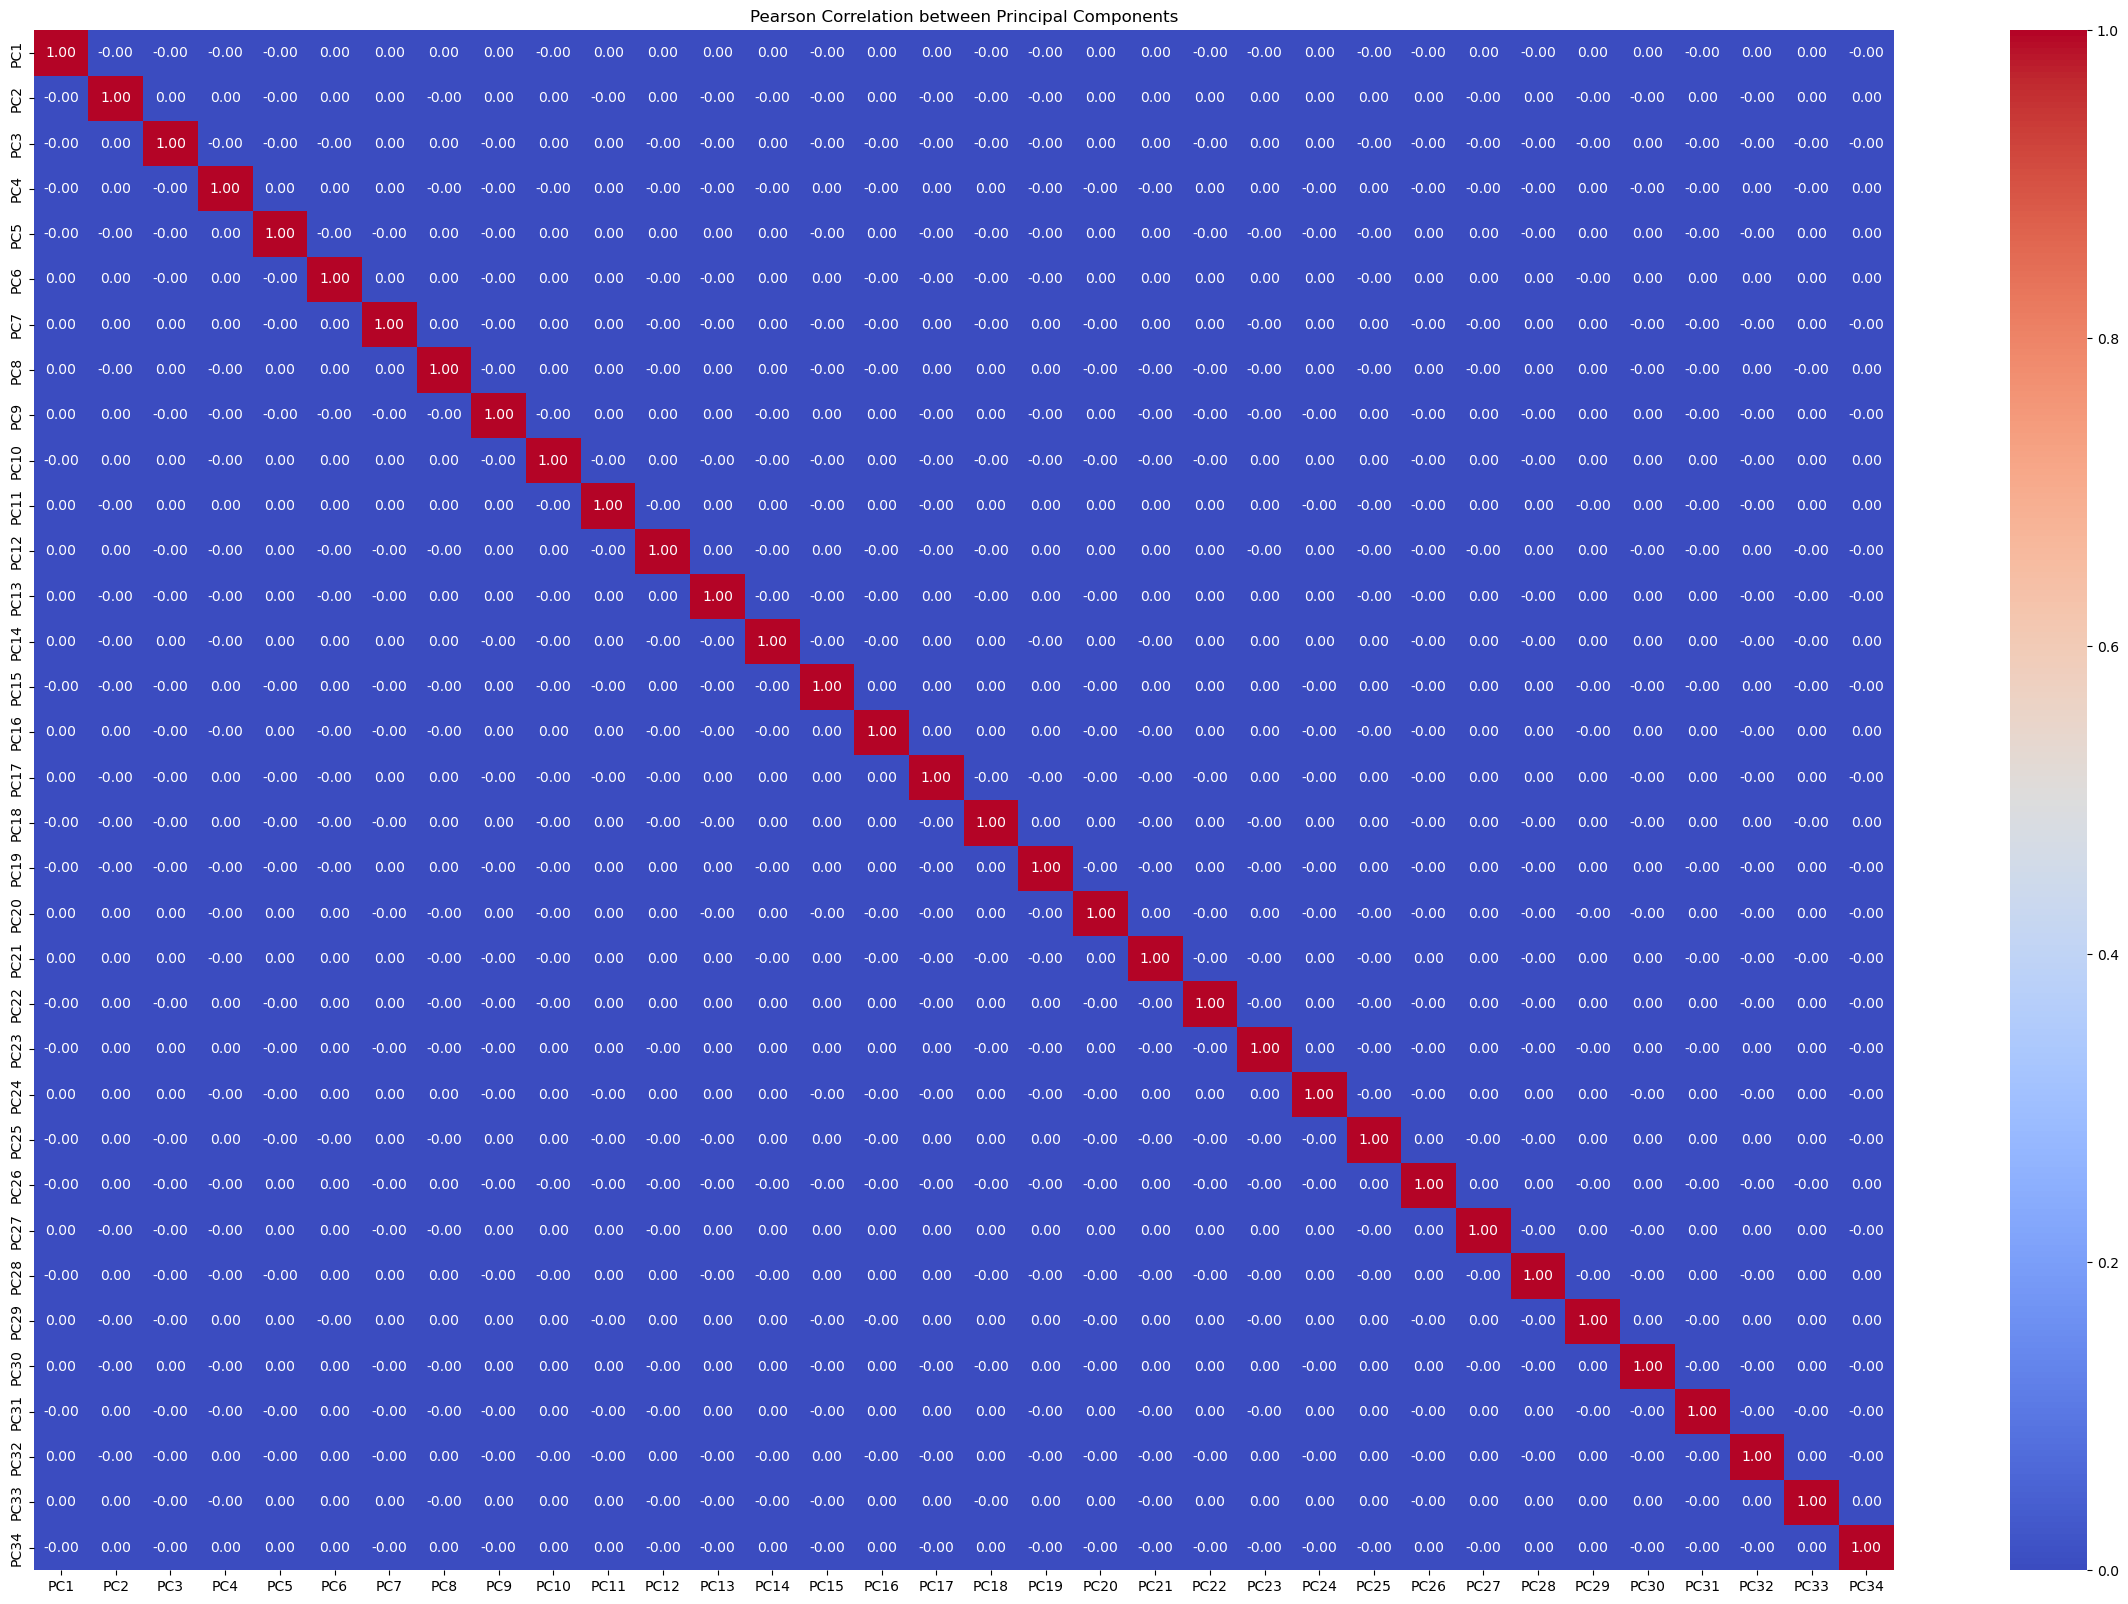

In [92]:
correlation_matrix = np.corrcoef(X_train_pca, rowvar=False)

plt.figure(figsize=(30, 20))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", xticklabels=pca_columns, yticklabels=pca_columns)
plt.title("Pearson Correlation between Principal Components")
plt.show()

In [93]:
param_grid = {
    'max_depth': range(1, 50),
    'min_samples_leaf': range(1, 50)
}
grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5)
grid_search.fit(X_train_pca, y_train)
best_params = grid_search.best_params_
print("Best Hyperparameters for DT with Highest Accuracy Score:", best_params)
best_model = DecisionTreeClassifier(**best_params)
best_model.fit(X_train_pca, y_train)
y_pred = best_model.predict(X_test_pca)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:\n', classification_report(y_test, y_pred))

Best Hyperparameters for DT with Highest Accuracy Score: {'max_depth': 8, 'min_samples_leaf': 1}
Accuracy: 0.92
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.94      0.94       408
           1       0.86      0.86      0.86       178

    accuracy                           0.92       586
   macro avg       0.90      0.90      0.90       586
weighted avg       0.92      0.92      0.92       586



In [94]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}

grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
grid_search.fit(X_train_pca, y_train)
best_params = grid_search.best_params_
print("Best Hyperparameters for RF with Highest Accuracy Score:", best_params)
best_model = RandomForestClassifier(**best_params, criterion= 'entropy')
best_model.fit(X_train_pca, y_train)
y_pred = best_model.predict(X_test_pca)
accuracy_rf = accuracy_score(y_test, y_pred)
print(f'Random Forest Accuracy: {accuracy_rf:.2f}')
print('Random Forest Classification Report:\n', classification_report(y_test, y_pred))

C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
360 fits failed out of a total of 720.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
360 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "C:\Users\jummy\anaconda3\Lib\site-packag

Best Hyperparameters for RF with Highest Accuracy Score: {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Random Forest Accuracy: 0.96
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97       408
           1       0.98      0.88      0.93       178

    accuracy                           0.96       586
   macro avg       0.97      0.94      0.95       586
weighted avg       0.96      0.96      0.96       586



In [103]:
param_grid = {
    'C': [10**i for i in range(-10,10)],
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid_search.fit(X_train_pca, y_train)
best_params = grid_search.best_params_
print("Best Hyperparameters for LR with Highest Accuracy Score:", best_params)
# Make predictions on the test set using the best model
best_model = LogisticRegression(**best_params)
best_model.fit(X_train_pca, y_train)
y_pred_cic_lr = best_model.predict(X_test_pca)
accuracy_lr = accuracy_score(y_test, y_pred_cic_lr)
print(f'Logistic Regression Accuracy: {accuracy_lr:.2f}')
print('Logistic Regression Classification Report:\n', classification_report(y_test, y_pred_cic_lr))

C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the

C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:

C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py

C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the

C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py

C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.

C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter 

C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1192: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


Best Hyperparameters for LR with Highest Accuracy Score: {'C': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}
Logistic Regression Accuracy: 0.94
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.96      0.96       408
           1       0.91      0.89      0.90       178

    accuracy                           0.94       586
   macro avg       0.93      0.92      0.93       586
weighted avg       0.94      0.94      0.94       586



C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\jummy\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

In [102]:
param_grid = {
    'C': range(1, 50),
    'gamma': ['scale', 'auto'] + list(np.logspace(-3, 3, 7))

}
grid_search = GridSearchCV(svm.SVC(kernel = 'linear'), param_grid, cv=5)
grid_search.fit(X_train_pca, y_train)
best_params = grid_search.best_params_
print("Best Hyperparameters for SVM with Highest Accuracy Score:", best_params)
best_model =  svm.SVC(kernel='linear', **best_params)
best_model.fit(X_train_pca, y_train)
y_pred_cic_svm = best_model.predict(X_test_pca)
accuracy_svm = accuracy_score(y_test, y_pred_cic_svm)
print(f'Support Vector Machine Accuracy: {accuracy_svm:.2f}')
print('Support Vector Machine Classification Report:\n', classification_report(y_test, y_pred_cic_svm))

Best Hyperparameters for SVM with Highest Accuracy Score: {'C': 16, 'gamma': 'scale'}
Support Vector Machine Accuracy: 0.94
Support Vector Machine Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.96      0.95       408
           1       0.90      0.89      0.90       178

    accuracy                           0.94       586
   macro avg       0.93      0.92      0.93       586
weighted avg       0.94      0.94      0.94       586



In [101]:
param_grid = {
    'C': [1,2,3],
    'gamma': ['scale', 'auto'] + list(np.logspace(-3, 3, 7)),
    'degree': [2, 3, 4],
    'coef0': [0.0, 0.1, 0.5]
}
grid_search = GridSearchCV(svm.SVC(kernel = 'rbf'), param_grid, cv=5)
grid_search.fit(X_train_pca, y_train)
best_params = grid_search.best_params_
print("Best Hyperparameters for SVM with Highest Accuracy Score:", best_params)
best_model =  svm.SVC(kernel='rbf', **best_params)
best_model.fit(X_train_pca, y_train)
y_pred_cic_svm = best_model.predict(X_test_pca)
accuracy_svm = accuracy_score(y_test, y_pred_cic_svm)
print(f'Support Vector Machine Accuracy: {accuracy_svm:.2f}')
print('Support Vector Machine Classification Report:\n', classification_report(y_test, y_pred_cic_svm))

Best Hyperparameters for SVM with Highest Accuracy Score: {'C': 3, 'coef0': 0.0, 'degree': 2, 'gamma': 0.1}
Support Vector Machine Accuracy: 0.96
Support Vector Machine Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97       408
           1       0.94      0.92      0.93       178

    accuracy                           0.96       586
   macro avg       0.95      0.95      0.95       586
weighted avg       0.96      0.96      0.96       586



In [100]:
param_grid_knn = {
    'n_neighbors': range(1, 50),
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid_knn, cv=5)
grid_search.fit(X_train_pca, y_train)
best_params = grid_search.best_params_
print("Best Hyperparameters for KNN with Highest Accuracy Score:", best_params)
best_model = KNeighborsClassifier(**best_params)
best_model.fit(X_train_pca, y_train)
y_pred = best_model.predict(X_test_pca)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:\n', classification_report(y_test, y_pred))

Best Hyperparameters for KNN with Highest Accuracy Score: {'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}
Accuracy: 0.94
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.97      0.96       408
           1       0.93      0.87      0.90       178

    accuracy                           0.94       586
   macro avg       0.94      0.92      0.93       586
weighted avg       0.94      0.94      0.94       586



In [97]:
param_grid = {
    'var_smoothing': np.logspace(0,-9, num=100)
}
grid_search = GridSearchCV(GaussianNB(), param_grid, cv=5)
grid_search.fit(X_train_pca, y_train)
best_params = grid_search.best_params_
print("Best Hyperparameters for GaussianNB with Highest Accuracy Score:", best_params)
best_model = GaussianNB(**best_params)
best_model.fit(X_train_pca, y_train)
y_pred = best_model.predict(X_test_pca)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:\n', classification_report(y_test, y_pred))

Best Hyperparameters for GaussianNB with Highest Accuracy Score: {'var_smoothing': 4.328761281083053e-06}
Accuracy: 0.80
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.92      0.87       408
           1       0.75      0.53      0.62       178

    accuracy                           0.80       586
   macro avg       0.78      0.73      0.75       586
weighted avg       0.80      0.80      0.79       586



In [96]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [6, 8, 10],
    'min_child_weight': [1, 5, 10],
    'gamma': [0.5, 1, 1.5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}
grid_search = GridSearchCV(xgb.XGBClassifier(), param_grid, cv=5)
grid_search.fit(X_train_pca, y_train)
best_params = grid_search.best_params_
print("Best Hyperparameters for XGB with Highest Accuracy Score:", best_params)
best_model = xgb.XGBClassifier(**best_params)
best_model.fit(X_train_pca, y_train)
y_pred = best_model.predict(X_test_pca)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:\n', classification_report(y_test, y_pred))

Best Hyperparameters for XGB with Highest Accuracy Score: {'colsample_bytree': 0.8, 'gamma': 0.5, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.6}
Accuracy: 0.95
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96       408
           1       0.94      0.89      0.91       178

    accuracy                           0.95       586
   macro avg       0.94      0.93      0.94       586
weighted avg       0.95      0.95      0.95       586



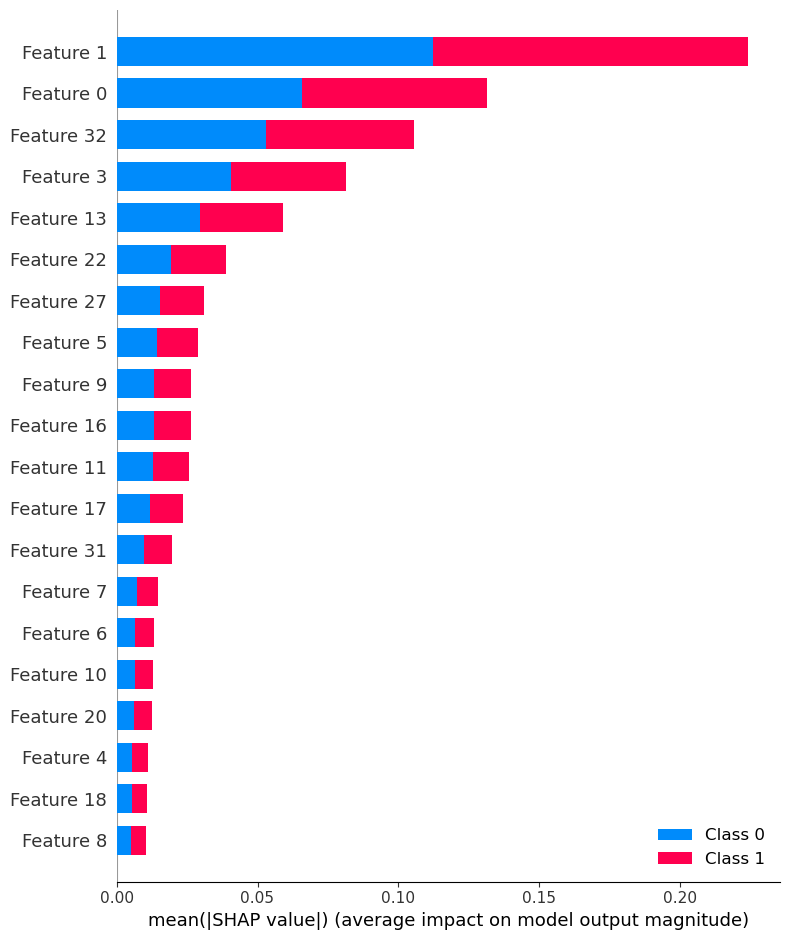

In [112]:
model = RandomForestClassifier(max_depth= 15, max_features= 'sqrt', min_samples_leaf= 1, min_samples_split=2, n_estimators= 200)
model.fit(X_train_pca, y_train)

# Explain the model's predictions
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_pca)

# Summary plot
shap.summary_plot(shap_values, X_test_pca)
# shap.plots.bar(shap_values)

Found 1238 images belonging to 2 classes.
Found 508 images belonging to 3 classes.
Found 386 images belonging to 2 classes.


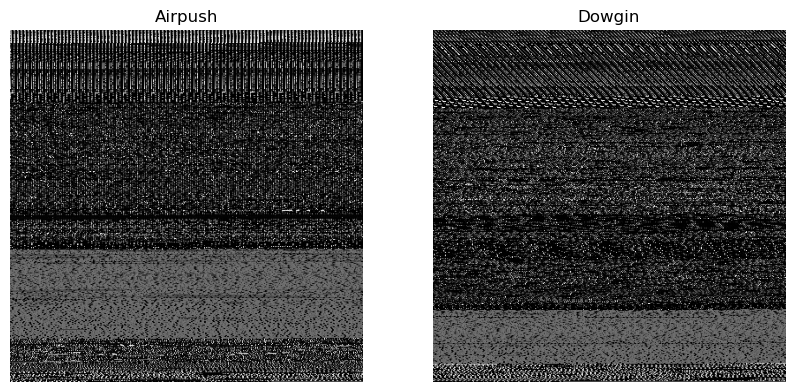

In [157]:
datagen = ImageDataGenerator(rescale=1./255,shear_range=0.2,zoom_range=0.2,horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load and Augment Training Data
train_generator = datagen.flow_from_directory(train_path,target_size=(224, 224),batch_size=32,class_mode='binary')
validation_generator = test_datagen.flow_from_directory(validation_path,target_size=(224, 224),batch_size=32,class_mode='binary',
                                                       shuffle=False)
test_generator = test_datagen.flow_from_directory(test_path,target_size=(224, 224),batch_size=32,class_mode='binary',
                                                 shuffle=False)


class_labels = train_generator.class_indices
class_names = list(class_labels.keys())

plt.figure(figsize=(10, 5))
for i, class_name in enumerate(class_names):
    class_idx = class_labels[class_name]
    img_indices = np.where(train_generator.classes == class_idx)[0]
    if img_indices.size > 0:
        img_path = train_generator.filepaths[img_indices[0]]
        img = plt.imread(img_path)
        plt.subplot(1, len(class_names), i + 1)
        plt.imshow(img)
        plt.title(class_name)
        plt.axis('off')
plt.show()


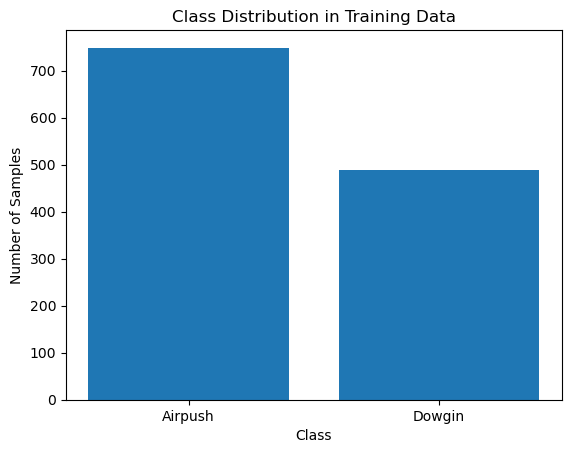

In [158]:
class_counts = np.unique(train_generator.classes, return_counts=True)

plt.bar(class_counts[0], class_counts[1], tick_label=class_names)
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in Training Data')
plt.show()

In [159]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

base_model.trainable = False

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Train the Model
history_img= model.fit(train_generator, epochs=10, validation_data=validation_generator)

# Evaluate on Test Data
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test Accuracy: {test_acc * 100:.2f}%')

Epoch 1/10
39/39 [==============================] - 140s 4s/step - loss: 1.0464 - accuracy: 0.6535 - val_loss: -0.5781 - val_accuracy: 0.4587
Epoch 2/10
39/39 [==============================] - 138s 4s/step - loss: 0.3644 - accuracy: 0.8522 - val_loss: -1.4602 - val_accuracy: 0.5354
Epoch 3/10
39/39 [==============================] - 137s 4s/step - loss: 0.2450 - accuracy: 0.9192 - val_loss: -2.2309 - val_accuracy: 0.5610
Epoch 4/10
39/39 [==============================] - 136s 4s/step - loss: 0.1907 - accuracy: 0.9297 - val_loss: -2.8153 - val_accuracy: 0.5571
Epoch 5/10
39/39 [==============================] - 138s 4s/step - loss: 0.1645 - accuracy: 0.9459 - val_loss: -2.8736 - val_accuracy: 0.5591
Epoch 6/10
39/39 [==============================] - 137s 4s/step - loss: 0.1784 - accuracy: 0.9338 - val_loss: -2.0959 - val_accuracy: 0.5492
Epoch 7/10
39/39 [==============================] - 136s 4s/step - loss: 0.1357 - accuracy: 0.9532 - val_loss: -3.0743 - val_accuracy: 0.5591
Epoch 

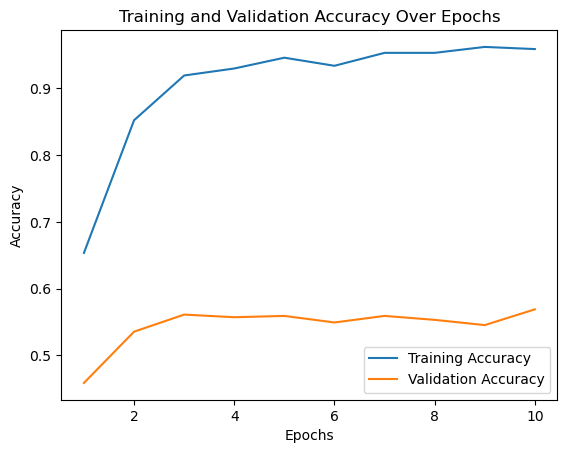

In [160]:
train_accuracy = history_img.history['accuracy']
val_accuracy = history_img.history['val_accuracy']

epochs_range = range(1, 11)

# Plotting the training and validation accuracy
plt.plot(epochs_range, train_accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.show()